---
title: "Network Creation"
---

## Import Required Libraries

In [1]:
import pandas as pd
import networkx as nx
from itertools import combinations
import ast
import matplotlib.pyplot as plt

## Load Dataframe

In [ ]:
df = pd.read_csv("../data/processed/cleaned_movies.csv")

## Actor/Director Collaboration Graph (Hetergenous Graph)

Network Architecture:
- Nodes: Actors + directors
- Edges: Collaborations between them (if they worked on the same movie)

In [137]:
# Create heterogeneous graph of actors + directors with collaboration edges
def create_crew_collaboration_network(df, save_path):
    # Create empty graph
    G = nx.Graph()

    df["Actors"] = df["Actors"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df["Directors"] = df["Directors"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


    # Iterate through rows in df
    for index, row in df.iterrows():
        # Track movie titles
        movie_title = row["Title"]

        # Add actor nodes
        for actor in row["Actors"]:
            if not G.has_node(actor):
                G.add_node(actor, type = "actor")
        
        # Add director nodes
        for director in row["Directors"]:
            if not G.has_node(director):
                G.add_node(director, type = "director")

        # Combine actors and directors as nodes in this movie
        collaborators = row["Actors"] + row["Directors"]
        
        # Add edges for all pairs of collaborators in this movie (undirected)
        for person_1, person_2 in combinations(collaborators, 2):
            if G.has_edge(person_1, person_2):
                # Append movie to the existing list of common movies
                G[person_1][person_2]["common_movies"].append(movie_title)

                # Increase collaboration weight if edge exists
                G[person_1][person_2]["weight"] += 1
            else:
                G.add_edge(person_1, person_2, weight = 1, common_movies = [movie_title])

    # For each edge, convert list attributes to strings
    for u, v, data in G.edges(data = True):
        for key, value in data.items():
            if isinstance(value, list):
                # Join list into semicolon-separated string
                data[key] = ";".join(value)

    # Save graph to GraphML format
    nx.write_graphml(G, f"{save_path}crew_collaboration_network.graphml")

    return G

In [138]:
df_sample = df.sample(n = 50, random_state = 777).copy()
df_sample = df[100:151].copy()
save_path = "../data/networks/"

G = create_crew_collaboration_network(df_sample, save_path)

## Movie Similarity Graph

Network Architecture:
- Nodes: Movies
- Edges: Movies sharing at least one actor or director.

In [139]:
# Create movie similarity graph based on shared actors/directors
def create_movie_similarity_network(df, save_path):
    # Create empty graph
    G = nx.Graph()

    df["Actors"] = df["Actors"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df["Directors"] = df["Directors"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Add movie nodes with some attributes
    for index, row in df.iterrows():
        movie_id = row["Title"]
        G.add_node(movie_id)

    # Build a dict: person -> set of movies they worked on
    person_to_movies = {}

    for index, row in df.iterrows():
        movie_id = row["Title"]
        collaborators = row["Actors"] + row["Directors"]

        for person in collaborators:
            person_to_movies.setdefault(person, set()).add(movie_id)

    # For each person, connect all movies they worked on
    for person, movies in person_to_movies.items():
        for movie_1, movie_2 in combinations(movies, 2):
            # Increase collaboration weight if edge exists
            if G.has_edge(movie_1, movie_2):
                # Append this person to the list of common collaborators on the edge
                G[movie_1][movie_2]["common_crew"].append(person)
                
                # Increase collaboration weight if edge exists
                G[movie_1][movie_2]["weight"] += 1

            else:
                G.add_edge(movie_1, movie_2, weight = 1, common_crew = [person])

    # For each edge, convert list attributes to strings
    for u, v, data in G.edges(data = True):
        for key, value in data.items():
            if isinstance(value, list):
                # Join list into semicolon-separated string
                data[key] = ";".join(value)

    # Save graph to GraphML format
    nx.write_graphml(G, f"{save_path}movie_similarity_network.graphml")

    return G

In [140]:
df_sample = df.sample(n = 50, random_state = 777).copy()
df_sample = df[100:151].copy()
save_path = "../data/networks/"

G = create_movie_similarity_network(df_sample, save_path)

## Visualize the Networks

### Crew Collaboration Network

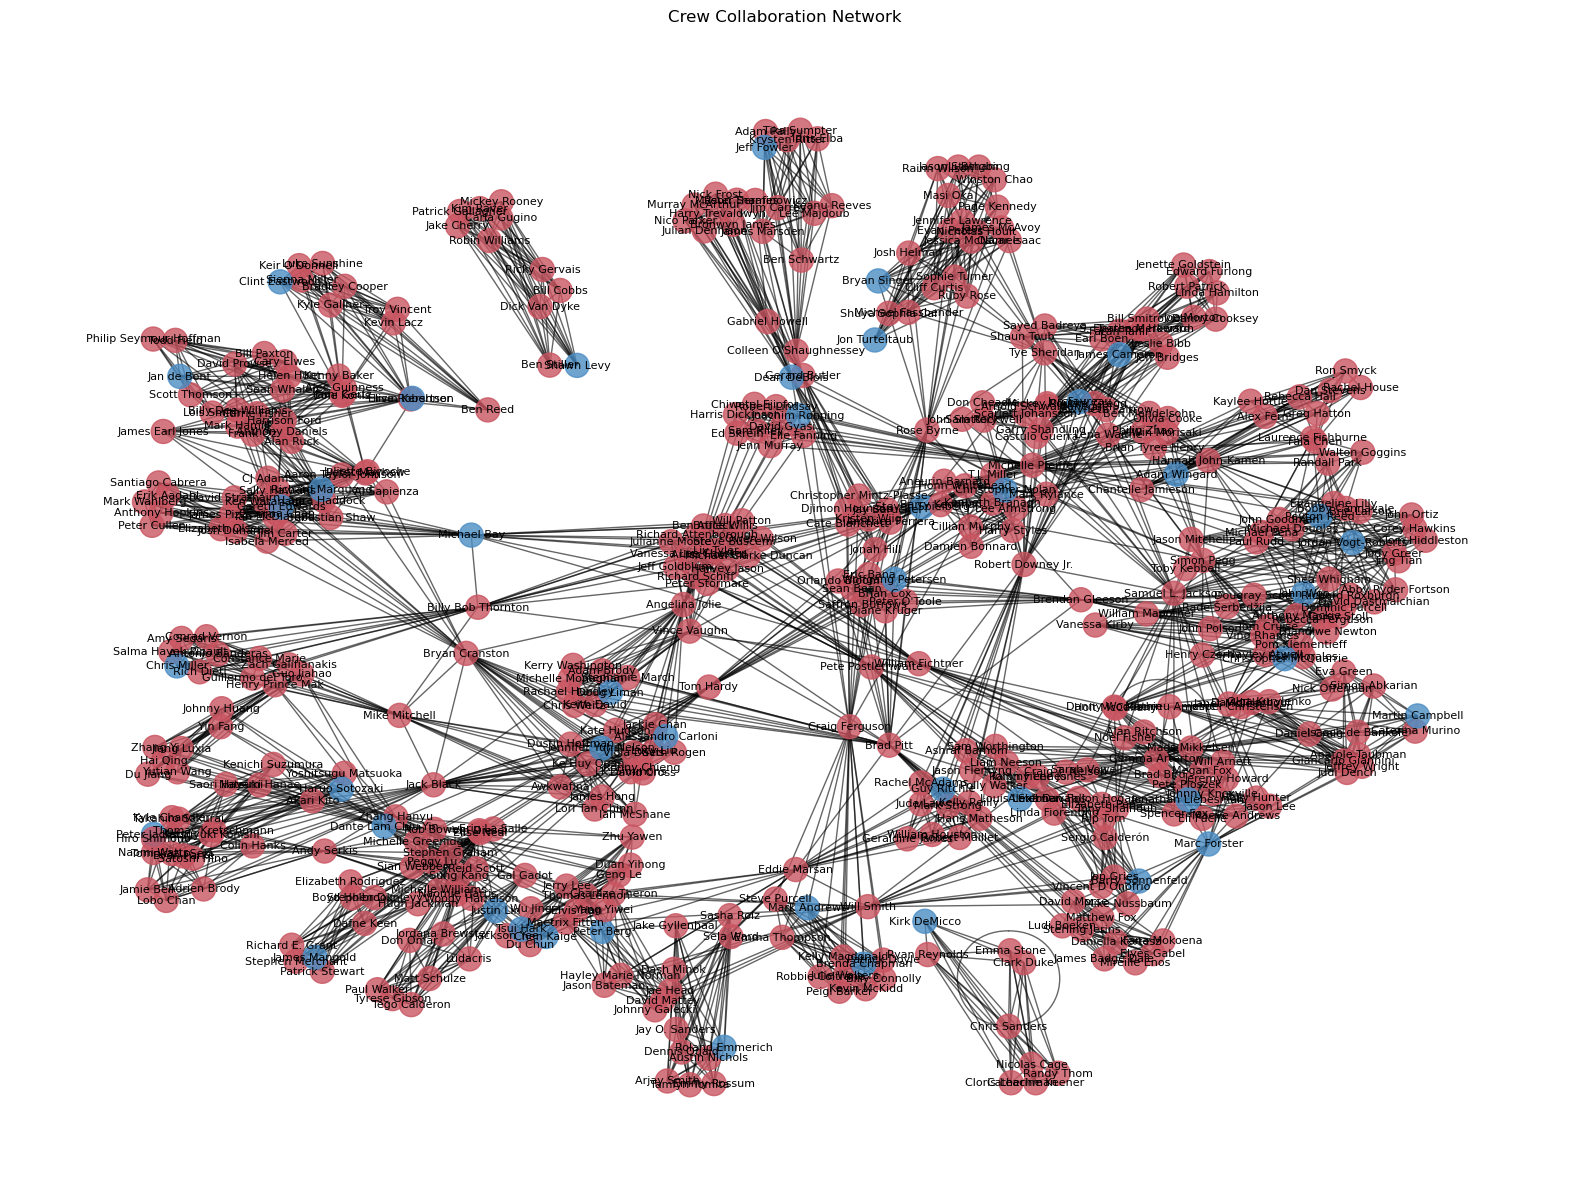

In [155]:
G = nx.read_graphml("../data/networks/crew_collaboration_network.graphml")

# Convert common_movies strings back to lists
for u, v, data in G.edges(data = True):
    if "common_movies" in data and isinstance(data["common_movies"], str):
        data["common_movies"] = data["common_movies"].split(";")

# Color nodes by type attribute
color_map = []
for node in G.nodes():
    node_type = G.nodes[node].get("type", "unknown")
    if node_type == "actor":
        color_map.append("#C95561")
    elif node_type == "director":
        color_map.append("#4B8DC4")
    else:
        color_map.append("gray")


plt.figure(figsize = (20, 15))

pos = nx.spring_layout(G, seed = 74, k = 0.5, iterations = 100, scale = 2)
# pos = nx.circular_layout(G)

nx.draw_networkx_nodes(G, pos, node_color = color_map, alpha = 0.8)
nx.draw_networkx_edges(G, pos, alpha = 0.6)
nx.draw_networkx_labels(G, pos, font_size = 8)

plt.title("Crew Collaboration Network")
plt.axis("off")
plt.show()

### Movie Similarity Network

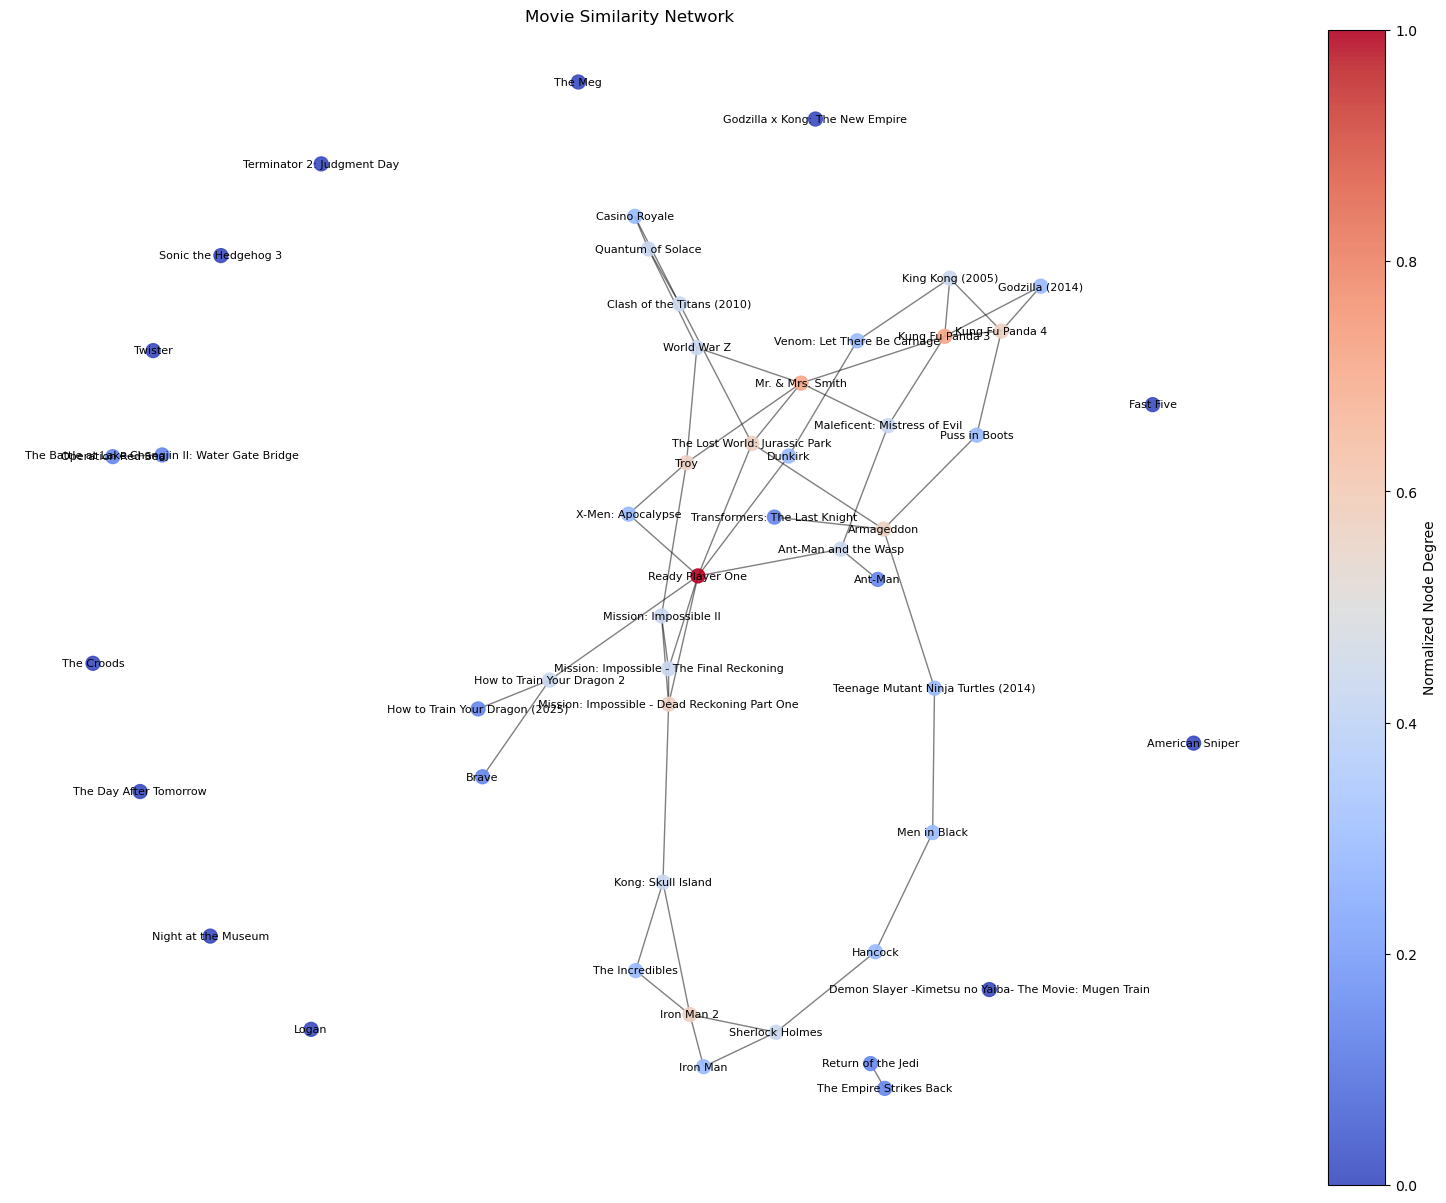

In [154]:
G = nx.read_graphml("../data/networks/movie_similarity_network.graphml")

# Convert common_crew strings back to lists
for u, v, data in G.edges(data = True):
    if "common_crew" in data and isinstance(data["common_crew"], str):
        data["common_crew"] = data["common_crew"].split(";")

# Calculate node degrees
degrees = dict(G.degree())
degree_values = list(degrees.values())

# Normalize degrees for coloring (optional)
max_degree = max(degree_values) if degree_values else 1
node_colors = [degree / max_degree for degree in degree_values]

plt.figure(figsize = (20, 15))

pos = nx.spring_layout(G, seed = 74, k = 1.0, iterations = 200, scale = 3)
# pos = nx.circular_layout(G)

# Draw nodes with color map (e.g., using a colormap from matplotlib)
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_color = node_colors,
    cmap = plt.cm.coolwarm,
    alpha = 0.9,
    node_size = 100,
)

nx.draw_networkx_edges(G, pos, alpha = 0.5)
nx.draw_networkx_labels(G, pos, font_size = 8)

plt.colorbar(nodes, label = "Normalized Node Degree")
plt.title("Movie Similarity Network")
plt.axis("off")
plt.show()